Random Forest that runs on histogram of the image 

Note: Histogram is imported from custom csv files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import argparse
import os
import numpy as np
import math
import itertools

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image
import pandas as pd

import torchvision.utils as vutils

import cv2

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [0]:
# paths from personal drive
csv_scored = 'scored_histograms.csv'
csv_query = 'query_histograms.csv'
cil_project = '/content/drive/My Drive/CIL_project/'
path_scored = cil_project + csv_scored
path_query = cil_project + csv_query

In [0]:
# copy the csv files for scored and query images
! cp '{path_scored}' . 
! cp '{path_query}' . 

In [21]:
# TRAINING IMAGES
train = pd.read_csv(csv_scored)
train.head(5)

,Unnamed: 0,Id,Actual,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,0,5694059,1.837794,998064.0,932.0,280.0,185.0,108.0,82.0,47.0,28.0,43.0,29.0,23.0,15.0,8.0,12.0,8.0,8.0,6.0,3.0,8.0,12.0,1.0,1.0,1.0,1.0,3.0,4.0,5.0,2.0,2.0,1.0,0.0,1.0,3.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,3.0,1.0,0.0,1.0
1,0,9129611,0.002067,541874.0,41577.0,40813.0,39288.0,37760.0,35726.0,33371.0,30939.0,28236.0,25807.0,22597.0,20125.0,17474.0,15198.0,12935.0,10981.0,9158.0,7650.0,6220.0,5027.0,3999.0,3140.0,2433.0,1931.0,1470.0,1108.0,783.0,607.0,483.0,316.0,232.0,151.0,113.0,90.0,60.0,47.0,38.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,8058479,4.588517,2.0,997302.0,1559.0,390.0,184.0,104.0,62.0,44.0,35.0,33.0,18.0,15.0,17.0,15.0,12.0,11.0,8.0,7.0,11.0,5.0,8.0,3.0,2.0,6.0,6.0,3.0,2.0,3.0,1.0,2.0,3.0,2.0,3.0,1.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,3.0,1.0,0.0,0.0,1.0,2.0,3.0,7.0,2.0,4.0,0.0,1.0
3,0,1315360,2.325835,3.0,2.0,996601.0,2048.0,476.0,207.0,129.0,78.0,60.0,36.0,37.0,33.0,24.0,16.0,17.0,13.0,10.0,15.0,7.0,4.0,9.0,7.0,4.0,3.0,4.0,3.0,3.0,7.0,3.0,1.0,3.0,2.0,4.0,4.0,0.0,3.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,5.0,8.0,2.0,4.0,1.0
4,0,6813515,0.872309,3.0,8.0,996391.0,2238.0,486.0,192.0,106.0,77.0,47.0,43.0,34.0,19.0,23.0,22.0,18.0,9.0,14.0,12.0,12.0,8.0,10.0,8.0,8.0,1.0,4.0,3.0,0.0,4.0,3.0,2.0,4.0,2.0,3.0,3.0,3.0,2.0,2.0,...,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,2.0,6.0,0.0,2.0,6.0,0.0,5.0,1.0,2.0,3.0,0.0,2.0,0.0,0.0,3.0,3.0,6.0,11.0,6.0,1.0,1.0,3.0,1.0


In [0]:
# CSV files are a bit weird, so get them in the appropiate form to feed the RF
# get the scores in a separate array
train_labels = train['Actual'].to_numpy()

# get the IDs in a separate array
train_id = train['Id'].to_numpy()


# get rid of columns we don't need 
# * there is randomly a column called Unnamed idk why
# * column Actual was saved in a different array 
# * Id is useless for training 
train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
train = train.loc[:, ~train.columns.str.contains('^Actual')]
train = train.loc[:, ~train.columns.str.contains('^Id')]

In [23]:
train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,998064.0,932.0,280.0,185.0,108.0,82.0,47.0,28.0,43.0,29.0,23.0,15.0,8.0,12.0,8.0,8.0,6.0,3.0,8.0,12.0,1.0,1.0,1.0,1.0,3.0,4.0,5.0,2.0,2.0,1.0,0.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,3.0,1.0,0.0,1.0
1,541874.0,41577.0,40813.0,39288.0,37760.0,35726.0,33371.0,30939.0,28236.0,25807.0,22597.0,20125.0,17474.0,15198.0,12935.0,10981.0,9158.0,7650.0,6220.0,5027.0,3999.0,3140.0,2433.0,1931.0,1470.0,1108.0,783.0,607.0,483.0,316.0,232.0,151.0,113.0,90.0,60.0,47.0,38.0,26.0,19.0,13.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2.0,997302.0,1559.0,390.0,184.0,104.0,62.0,44.0,35.0,33.0,18.0,15.0,17.0,15.0,12.0,11.0,8.0,7.0,11.0,5.0,8.0,3.0,2.0,6.0,6.0,3.0,2.0,3.0,1.0,2.0,3.0,2.0,3.0,1.0,0.0,2.0,1.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,3.0,1.0,0.0,0.0,1.0,2.0,3.0,7.0,2.0,4.0,0.0,1.0
3,3.0,2.0,996601.0,2048.0,476.0,207.0,129.0,78.0,60.0,36.0,37.0,33.0,24.0,16.0,17.0,13.0,10.0,15.0,7.0,4.0,9.0,7.0,4.0,3.0,4.0,3.0,3.0,7.0,3.0,1.0,3.0,2.0,4.0,4.0,0.0,3.0,1.0,4.0,2.0,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,5.0,8.0,2.0,4.0,1.0
4,3.0,8.0,996391.0,2238.0,486.0,192.0,106.0,77.0,47.0,43.0,34.0,19.0,23.0,22.0,18.0,9.0,14.0,12.0,12.0,8.0,10.0,8.0,8.0,1.0,4.0,3.0,0.0,4.0,3.0,2.0,4.0,2.0,3.0,3.0,3.0,2.0,2.0,4.0,3.0,1.0,...,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,2.0,6.0,0.0,2.0,6.0,0.0,5.0,1.0,2.0,3.0,0.0,2.0,0.0,0.0,3.0,3.0,6.0,11.0,6.0,1.0,1.0,3.0,1.0


In [24]:
train_labels

array([1.83779393e+00, 2.06706030e-03, 4.58851701e+00, ...,
       1.30838758e+00, 3.69750028e+00, 1.43068864e+00])

In [25]:
len(train_labels)

9600

In [0]:
# QUERY IMAGES
test = pd.read_csv(csv_query)

In [27]:
test.head(5)

,Unnamed: 0,Id,Actual,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,0,8042027,-1,995632.0,2562.0,666.0,323.0,175.0,116.0,94.0,73.0,45.0,35.0,29.0,22.0,18.0,13.0,8.0,7.0,14.0,11.0,9.0,9.0,10.0,3.0,4.0,6.0,8.0,5.0,4.0,3.0,2.0,1.0,3.0,2.0,1.0,3.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,2679287,-1,994022.0,3882.0,646.0,301.0,186.0,116.0,93.0,78.0,55.0,38.0,43.0,27.0,23.0,28.0,18.0,20.0,19.0,11.0,15.0,15.0,7.0,15.0,15.0,11.0,14.0,7.0,9.0,5.0,9.0,8.0,6.0,5.0,8.0,9.0,7.0,3.0,1.0,...,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,4.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,4.0,1.0,1.0,1.0,6.0,6.0,11.0,2.0,0.0,2.0,2.0,1.0
2,0,6664898,-1,469416.0,30789.0,30884.0,30277.0,30335.0,30048.0,29084.0,27954.0,27332.0,26155.0,24672.0,23547.0,21935.0,20941.0,19494.0,17988.0,16326.0,15074.0,13741.0,12364.0,10978.0,9759.0,8758.0,7846.0,6729.0,5843.0,5164.0,4327.0,3803.0,3288.0,2671.0,2305.0,1823.0,1544.0,1301.0,1052.0,881.0,...,3.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,2.0,0.0,4.0,2.0,1.0,4.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,1.0,0.0,3.0,0.0,17.0
3,0,8523812,-1,531388.0,30885.0,30726.0,30260.0,29318.0,28118.0,27109.0,26128.0,24969.0,23755.0,22094.0,20896.0,19275.0,17792.0,16559.0,14889.0,13571.0,12397.0,10862.0,9723.0,8757.0,7689.0,6614.0,5636.0,5031.0,4372.0,3678.0,3091.0,2631.0,2100.0,1776.0,1502.0,1261.0,987.0,832.0,668.0,506.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,3.0,1.0,0.0,10.0
4,0,6478640,-1,2.0,996011.0,2520.0,437.0,181.0,126.0,71.0,67.0,33.0,36.0,23.0,16.0,28.0,20.0,13.0,9.0,20.0,10.0,9.0,12.0,9.0,9.0,10.0,7.0,5.0,5.0,6.0,7.0,4.0,11.0,8.0,6.0,7.0,2.0,3.0,4.0,2.0,...,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,2.0,3.0,1.0,0.0,2.0,1.0,0.0,1.0,3.0,3.0,1.0,2.0,0.0,1.0,2.0,3.0,4.0,5.0,5.0,1.0,3.0,5.0,6.0,18.0,2.0,0.0,2.0,0.0,3.0,1.0


In [0]:
# CSV files are a bit weird, so get them in the appropiate form to feed the RF
test_id = test['Id'].to_numpy()

# get rid of columns we don't need 
# * there is randomly a column called Unnamed idk why
# * column Actual initially had just values -1 anyway  
# * id is useless for training, and was exported in different array
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Actual')]
test = test.loc[:, ~test.columns.str.contains('^Id')]

In [29]:
test.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,995632.0,2562.0,666.0,323.0,175.0,116.0,94.0,73.0,45.0,35.0,29.0,22.0,18.0,13.0,8.0,7.0,14.0,11.0,9.0,9.0,10.0,3.0,4.0,6.0,8.0,5.0,4.0,3.0,2.0,1.0,3.0,2.0,1.0,3.0,3.0,2.0,0.0,2.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,994022.0,3882.0,646.0,301.0,186.0,116.0,93.0,78.0,55.0,38.0,43.0,27.0,23.0,28.0,18.0,20.0,19.0,11.0,15.0,15.0,7.0,15.0,15.0,11.0,14.0,7.0,9.0,5.0,9.0,8.0,6.0,5.0,8.0,9.0,7.0,3.0,1.0,2.0,4.0,4.0,...,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,4.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,4.0,1.0,1.0,1.0,6.0,6.0,11.0,2.0,0.0,2.0,2.0,1.0
2,469416.0,30789.0,30884.0,30277.0,30335.0,30048.0,29084.0,27954.0,27332.0,26155.0,24672.0,23547.0,21935.0,20941.0,19494.0,17988.0,16326.0,15074.0,13741.0,12364.0,10978.0,9759.0,8758.0,7846.0,6729.0,5843.0,5164.0,4327.0,3803.0,3288.0,2671.0,2305.0,1823.0,1544.0,1301.0,1052.0,881.0,729.0,550.0,460.0,...,3.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,2.0,0.0,4.0,2.0,1.0,4.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,1.0,0.0,3.0,0.0,17.0
3,531388.0,30885.0,30726.0,30260.0,29318.0,28118.0,27109.0,26128.0,24969.0,23755.0,22094.0,20896.0,19275.0,17792.0,16559.0,14889.0,13571.0,12397.0,10862.0,9723.0,8757.0,7689.0,6614.0,5636.0,5031.0,4372.0,3678.0,3091.0,2631.0,2100.0,1776.0,1502.0,1261.0,987.0,832.0,668.0,506.0,441.0,362.0,275.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,3.0,1.0,0.0,10.0
4,2.0,996011.0,2520.0,437.0,181.0,126.0,71.0,67.0,33.0,36.0,23.0,16.0,28.0,20.0,13.0,9.0,20.0,10.0,9.0,12.0,9.0,9.0,10.0,7.0,5.0,5.0,6.0,7.0,4.0,11.0,8.0,6.0,7.0,2.0,3.0,4.0,2.0,3.0,5.0,8.0,...,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,2.0,3.0,1.0,0.0,2.0,1.0,0.0,1.0,3.0,3.0,1.0,2.0,0.0,1.0,2.0,3.0,4.0,5.0,5.0,1.0,3.0,5.0,6.0,18.0,2.0,0.0,2.0,0.0,3.0,1.0


In [0]:
# function to normalise column-wise
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [0]:
# train = normalize(train)
# test = normalize(test)

In [32]:
train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,998064.0,932.0,280.0,185.0,108.0,82.0,47.0,28.0,43.0,29.0,23.0,15.0,8.0,12.0,8.0,8.0,6.0,3.0,8.0,12.0,1.0,1.0,1.0,1.0,3.0,4.0,5.0,2.0,2.0,1.0,0.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,3.0,1.0,0.0,1.0
1,541874.0,41577.0,40813.0,39288.0,37760.0,35726.0,33371.0,30939.0,28236.0,25807.0,22597.0,20125.0,17474.0,15198.0,12935.0,10981.0,9158.0,7650.0,6220.0,5027.0,3999.0,3140.0,2433.0,1931.0,1470.0,1108.0,783.0,607.0,483.0,316.0,232.0,151.0,113.0,90.0,60.0,47.0,38.0,26.0,19.0,13.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2.0,997302.0,1559.0,390.0,184.0,104.0,62.0,44.0,35.0,33.0,18.0,15.0,17.0,15.0,12.0,11.0,8.0,7.0,11.0,5.0,8.0,3.0,2.0,6.0,6.0,3.0,2.0,3.0,1.0,2.0,3.0,2.0,3.0,1.0,0.0,2.0,1.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,3.0,1.0,0.0,0.0,1.0,2.0,3.0,7.0,2.0,4.0,0.0,1.0
3,3.0,2.0,996601.0,2048.0,476.0,207.0,129.0,78.0,60.0,36.0,37.0,33.0,24.0,16.0,17.0,13.0,10.0,15.0,7.0,4.0,9.0,7.0,4.0,3.0,4.0,3.0,3.0,7.0,3.0,1.0,3.0,2.0,4.0,4.0,0.0,3.0,1.0,4.0,2.0,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,5.0,8.0,2.0,4.0,1.0
4,3.0,8.0,996391.0,2238.0,486.0,192.0,106.0,77.0,47.0,43.0,34.0,19.0,23.0,22.0,18.0,9.0,14.0,12.0,12.0,8.0,10.0,8.0,8.0,1.0,4.0,3.0,0.0,4.0,3.0,2.0,4.0,2.0,3.0,3.0,3.0,2.0,2.0,4.0,3.0,1.0,...,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,2.0,6.0,0.0,2.0,6.0,0.0,5.0,1.0,2.0,3.0,0.0,2.0,0.0,0.0,3.0,3.0,6.0,11.0,6.0,1.0,1.0,3.0,1.0


In [45]:
# Fitting the Regression model to dataset
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
print(regressor)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)


In [46]:
regressor.fit(train, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [0]:
# Predict for query images
pred = regressor.predict(test)

In [47]:
print(pred.shape)
print(np.max(pred))
print(np.min(pred))

(1200,)
4.47601451296
0.0005601791244813404


(array([150.,  57., 136., 321., 168., 148., 130.,  70.,  19.,   1.]),
 array([5.60179124e-04, 4.48105613e-01, 8.95651046e-01, 1.34319648e+00,
        1.79074191e+00, 2.23828735e+00, 2.68583278e+00, 3.13337821e+00,
        3.58092365e+00, 4.02846908e+00, 4.47601451e+00]),
 <a list of 10 Patch objects>)

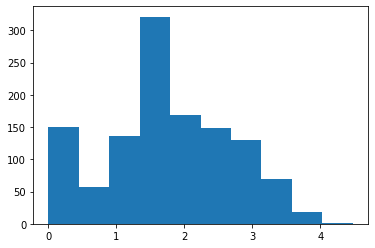

In [48]:
plt.hist(pred)

In [51]:
# RMSE of training data
preds_train = regressor.predict(train)
rmse_regressor = np.sqrt(mean_squared_error(train_labels,preds_train))
print('RMSE: %.4f' % rmse_regressor)

RMSE: 0.2020


In [62]:
# Predict for test images
index_smallest = np.where(preds_train == np.min(preds_train))

# lowest score
print(np.min(preds_train))

# images IDs of images with lowest given score
print(train_id[index_smallest])

# actual score
print(train_labels[index_smallest])

0.0005648530549078615
[3651013 7952766 6922456 2334106 7545270 3537999 1461712 7458169 3055031
 8256013 6295889 7559528 8341734 6906069 7623622 9784001 1976895 5186434
 2076747 2456801 7352046 9168766 7395776 2470697 7677966 4365724 2388462
 2866866 5560427 2053118 3838505 1565272 1026604 3882612 4448854 3884620
 1323790 6406584 7849333 8801628 3915282 5090789 5503327 5305845 4117722
 3850300 4308100 9376045 4439075 8013896 3721713 5014537 4772988 3813041
 7202038 1580501 6240443 6582649 7727580 1980326 8947749 6134028 6416424
 6557533 2517182 5440751 3143366 9671698 4418193 2410261 8907562 9560662
 1218916 3412633 5658043 5777307 3920059 7716422 6740634 4935393 4087734
 1109209 6855293 6252384 5736659 3359762 9268961 4179314 1747736 7882359
 2009052 2602471 6678884 7389725 3044857 5192814 2838217 6900835 5152214
 2739604 5130367 1492328 3863496 2291186 9893828 8380161 7519289 6757249
 7321744 7061376 9629057 1568560 8108365 2272699 5020944 3694850 9442701
 8013915 8374803 2615790 1413

In [0]:
# create dataframe for submission
results = pd.DataFrame(columns=["Id", "Predicted"])

for i in range(len(pred)):
  new_row = pd.DataFrame([[test_id[i], pred[i]]], columns=["Id", "Predicted"])
  results = results.append(new_row)

In [0]:
results = results.set_index("Id")

In [0]:
# csv for submission
resuts.to_csv("/content/drive/My Drive/CIL_project/out.csv")

In [0]:
# save model of random forest
import cPickle
with open('/content/drive/My Drive/CIL_project/model.pkl', 'wb') as f:
    cPickle.dump(regressor, f)
